In [3]:
import pandas as pd
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from multiprocessing import Pool, cpu_count
from matplotlib import patches, patheffects
import math

from fastai.dataset import *
from fastai.conv_learner import *

In [4]:
% load_ext autoreload
% autoreload 2
% matplotlib inline

In [5]:
from pathlib import Path

In [6]:
ddir = "/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge"

In [7]:
rsna_path = Path(ddir)

In [13]:
detailed_class_info_csv = pd.read_csv(rsna_path/'stage_1_detailed_class_info.csv')

In [14]:
stage_1_sample_submission_csv = pd.read_csv(rsna_path/'stage_1_sample_submission.csv')

In [15]:
stage_1_train_labels_csv = pd.read_csv(rsna_path/'stage_1_train_labels.csv')

In [16]:
train_images = list((rsna_path/'train/').glob('*.dcm'))

In [174]:
test_images = list((rsna_path/'test/').glob('*.dcm'))

In [166]:
test_images

[PosixPath('/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/test/b215a2cf-ddf6-4032-99a0-1c2b10ef2f9e.dcm'),
 PosixPath('/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/test/3a1c6cb8-cb42-44c7-8d5a-925f813427c7.dcm'),
 PosixPath('/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/test/cd393b1b-1d2b-4ce1-9cb4-6e0065139ae2.dcm'),
 PosixPath('/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/test/773b06e8-efab-4ee3-94c8-9ef0f01af291.dcm'),
 PosixPath('/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/test/ee05c3bf-cadf-4aa4-85cb-d8f52608fb44.dcm'),
 PosixPath('/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/test/f137d0ae-b2f7-4fd1-916d-773d4695b626.dcm'),
 PosixPath('/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/test/31dfda01-0949-4b8d-93e0-61f49f2b4a3c.dcm'),
 PosixPath('/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/test/dbb5

In [48]:
# First step to open dcm files

In [10]:
ds = pydicom.dcmread(str(train_images[0]))

In [13]:
# dir(ds)

In [14]:
# ds.PatientAge

In [15]:
# ds.pixel_array

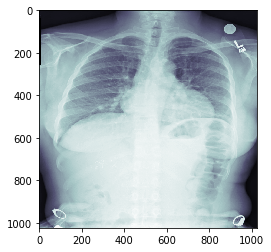

In [11]:
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

'b215a2cf-ddf6-4032-99a0-1c2b10ef2f9e'

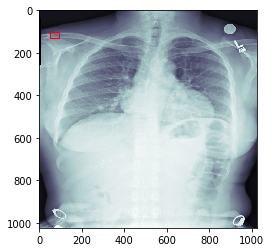

In [17]:
# Show a Bounding Box
fig, ax = plt.subplots(1)
ax.imshow(ds.pixel_array, cmap=plt.cm.bone)
rect = Rectangle((50,100),40,30,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ds.PatientID

In [18]:
stage_1_train_labels_csv[:10]

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

In [19]:
stage_1_train_labels_csv[stage_1_train_labels_csv['patientId'] == 'b215a2cf-ddf6-4032-99a0-1c2b10ef2f9e']

patientId   x   y  width  height  Target
19064  b215a2cf-ddf6-4032-99a0-1c2b10ef2f9e NaN NaN    NaN     NaN       0

In [20]:
def get_ds_file(file):
    ds = pydicom.dcmread(str(file))
    return {
        'file': str(file).split('/')[-1].split('.dcm')[0],
        'ds': ds
    }

In [21]:
train_images_map = list(map(get_ds_file, train_images))

In [56]:
def find_by_id(id):
    return list(filter(lambda x: x['file'] == id, train_images_map))

In [57]:
find_by_id('b215a2cf-ddf6-4032-99a0-1c2b10ef2f9e')[0]['ds'].pixel_array

array([[177,  56,  38, ...,  18,  18,  18],
       [ 97,  41,  37, ...,  21,  21,  21],
       [ 42,  35,  28, ...,  22,  22,  22],
       ..., 
       [185, 176, 169, ...,  16,  16,  16],
       [191, 183, 175, ...,  16,  16,  16],
       [197, 188, 181, ...,  16,  16,  17]], dtype=uint8)

In [58]:
def select_by_id(id):
    return stage_1_train_labels_csv[stage_1_train_labels_csv['patientId'] == id]

In [59]:
def show_img_by_id(id):
    ds = find_by_id(id)[0]['ds']
    pixel_array = find_by_id(id)[0]['ds'].pixel_array
    fig, ax = plt.subplots(1)
    ax.imshow(ds.pixel_array, cmap=plt.cm.bone)
    
    _, x, y, width, height, _  = select_by_id(id).iloc[0]
    rect = Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

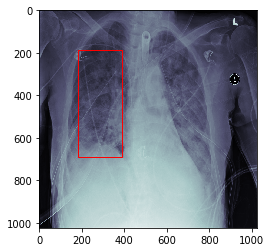

In [60]:
show_img_by_id('00f08de1-517e-4652-a04f-d1dc9ee48593')

In [61]:
show_img_by_id('ffd787b6-59ca-48cb-bd15-bcedd52cf37c')

In [62]:
len(train_images_map)

25684

In [63]:
metrics = []

In [64]:
not_nan_values = stage_1_train_labels_csv[~np.isnan(stage_1_train_labels_csv['width'])]

#### of train dataset 8964 / 25684 samples are not NaN 34%

In [65]:
len(not_nan_values)

8964

In [66]:
sample_labels = stage_1_train_labels_csv[0:1000]

In [67]:
8964 / 25684

0.3490110574676842

In [68]:
n_sample = len(sample_labels); n_sample

1000

In [69]:
not_nan_samples = sample_labels[~np.isnan(sample_labels['width'])]

In [70]:
len(not_nan_samples)

428

In [71]:
not_nan_samples

patientId      x      y  width  height  Target
4    00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5    00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
8    00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9    00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1
14   00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0       1
15   00aecb01-a116-45a2-956c-08d2fa55433f  547.0  299.0  119.0   165.0       1
16   00c0b293-48e7-4e16-ac76-9269ba535a62  306.0  544.0  168.0   244.0       1
17   00c0b293-48e7-4e16-ac76-9269ba535a62  650.0  511.0  206.0   284.0       1
19   00f08de1-517e-4652-a04f-d1dc9ee48593  181.0  184.0  206.0   506.0       1
20   00f08de1-517e-4652-a04f-d1dc9ee48593  571.0  275.0  230.0   476.0       1
22   0100515c-5204-4f31-98e0-f35e4b00004a  703.0  416.0   84.0    77.0       1
24   010ccb9f-6d46-4380-af11-84f87397a1b8  652.0  437.0  161.0   293.0       1
25   010ccb9f-6d46-4380-af11-84f87397a1b8  301.0  405.0  141.0   279.0       1
27   012a5620-d082-4bb8-9b3b-e72d8938000c  133.0  613.0  275.0   275.0       1
28   012a5620-d082-4bb8-9b3b-e72d8938000c  678.0  427.0  224.0   340.0       1
32   0174c4bb-28f5-41e3-a13f-a396badc18bd  155.0  182.0  273.0   501.0       1
33   0174c4bb-28f5-41e3-a13f-a396badc18bd  599.0  220.0  227.0   508.0       1
36   019d950b-dd38-4cf3-a686-527a75728be6  229.0  318.0  250.0   301.0       1
37   019d950b-dd38-4cf3-a686-527a75728be6  604.0  216.0  196.0   328.0       1
41   01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce  141.0  306.0  225.0   327.0       1
42   01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce  609.0  285.0  236.0   355.0       1
43   01a7353d-25bb-4ff8-916b-f50dd541dccf  214.0  582.0  239.0   133.0       1
44   01a7353d-25bb-4ff8-916b-f50dd541dccf  664.0  540.0  223.0   203.0       1
46   01adfd2f-7bc7-4cef-ab68-a0992752b620  225.0  415.0   98.0   101.0       1
49   01b9e362-4950-40f5-88fa-7557ac2a45bb  366.0  289.0  208.0   527.0       1
50   01b9e362-4950-40f5-88fa-7557ac2a45bb  714.0  278.0  255.0   576.0       1
51   01be392f-a46d-4aef-a57e-9cd1a80dd47e  535.0  626.0  177.0   240.0       1
52   01be392f-a46d-4aef-a57e-9cd1a80dd47e  175.0  825.0  168.0   109.0       1
57   01cad8d0-45cd-4603-b099-94055d322310  218.0  667.0  258.0   324.0       1
58   01cad8d0-45cd-4603-b099-94055d322310  756.0  556.0  225.0   441.0       1
..                                    ...    ...    ...    ...     ...     ...
888  0b3b1768-5926-4084-bed0-ad9ae886d13a  176.0  355.0  242.0   202.0       1
889  0b3b1768-5926-4084-bed0-ad9ae886d13a  494.0  292.0  249.0   301.0       1
910  0b5fa34f-5c96-4cc5-becc-317acdff3221  546.0  292.0  223.0   362.0       1
924  0b74faac-00a1-4958-9571-b5f7f9c52179  169.0  287.0  265.0   343.0       1
926  0b7a4fb2-adab-484b-a0f7-23f5111bc745  557.0  185.0  335.0   686.0       1
927  0b7a4fb2-adab-484b-a0f7-23f5111bc745  220.0  177.0  236.0   709.0       1
938  0b8e881f-67bc-4021-a02c-0087233e43aa  629.0  506.0  257.0   278.0       1
939  0b8e881f-67bc-4021-a02c-0087233e43aa  165.0  427.0  256.0   318.0       1
940  0b8f8765-0406-447c-b873-7ac5ce8884aa  546.0  320.0  342.0   301.0       1
947  0ba245bb-b2e4-49b1-8c63-576e38470708  226.0  289.0  247.0   354.0       1
948  0ba245bb-b2e4-49b1-8c63-576e38470708  568.0  210.0  257.0   660.0       1
953  0bae27f3-01d4-4223-adc5-d3264e0d9213  126.0  321.0  298.0   171.0       1
954  0bae27f3-01d4-4223-adc5-d3264e0d9213  553.0  288.0  250.0   501.0       1
963  0bbb1ff7-dba6-4d5b-affe-b3ca0050d965   65.0  445.0  265.0   255.0       1
966  0bbe0f92-940f-431a-b8c4-3b371ea7d9aa  313.0  430.0  211.0   256.0       1
967  0bbe0f92-940f-431a-b8c4-3b371ea7d9aa  615.0  278.0  332.0   320.0       1
972  0bc7f47a-ecea-4b66-811e-096004721a63  621.0  645.0  172.0   179.0       1
975  0bcfe7ee-ada5-48de-990b-2a2fd6c6ed15  571.0  290.0  212.0   259.0       1
976  0bcfe7ee-ada5-48de-990b-2a2fd6c6ed15  263.0  440.0  177.0   141.0       1
977

In [22]:
PNG_PATH = '/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/train_png/'

In [180]:
TEST_PNG_PATH = '/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/test_png/'

In [74]:
fmodel = resnet34
sz = 224
bs = 64

In [75]:
tfms = tfms_from_model(fmodel, sz, crop_type=CropType.NO)

In [76]:
?? ImageClassifierData.from_csv

In [77]:
# save_as_png(train_images[0])

In [78]:
def save_as_png(file):
    key = str(file).split('/')[-1].split('.dcm')[0]
    ds = pydicom.dcmread(str(file))
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    png_path = f"{PNG_PATH}{key}.png"
    if os.path.isfile(png_path) and os.access(png_path, os.R_OK):
        print("FILE EXISTS. SKIPPING")
    else:
        plt.savefig(png_path)

In [172]:
def save_as_png_test(file):
    key = str(file).split('/')[-1].split('.dcm')[0]
    ds = pydicom.dcmread(str(file))
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    png_path = f"{TEST_PNG_PATH}{key}.png"
    if os.path.isfile(png_path) and os.access(png_path, os.R_OK):
        print("FILE EXISTS. SKIPPING")
    else:
        plt.savefig(png_path)

In [80]:
# p = Pool(64)

In [81]:
# p.map(save_as_png_test, test_images)

In [82]:
# list(map(save_as_png, train_images))

In [83]:
 # p = Pool(64)

In [84]:
# p.map(save_as_png, train_images)

In [85]:
PNG_PATH

'/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/train_png/'

In [86]:
! ls {PNG_PATH} -l | wc -l

25685


In [87]:
png_list = list(Path(PNG_PATH).glob('*.png'))

In [88]:
len(train_images)

25684

In [121]:
len(png_list)

25684

In [90]:
def get_key(file):
    key = str(file).split("/")[-1].split('.')[0]
    return str(key).strip()

In [91]:
# png_keys = list(map(get_key, png_list))

In [92]:
# keys = list(map(get_key, train_images))

In [93]:
# keys

In [94]:
# png_keys[0] not in keys

In [95]:
# missing_keys = [key for key in keys if key not in png_keys]

In [96]:
# len(missing_keys)

In [97]:
f"/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/train/{missing_keys[0]}.dcm"

NameError: name 'missing_keys' is not defined

In [98]:
def save_as_missing_png(key):
    file = f"/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/train/{key}.dcm"
    ds = pydicom.dcmread(str(file))
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    png_path = f"{PNG_PATH}{key}.png"
    if os.path.isfile(png_path) and os.access(png_path, os.R_OK):
        print("FILE EXISTS. SKIPPING")
    else:
        print(f"SAVING FILE - {key}")
        plt.savefig(png_path)

SAVING FILE - a4cba60f-6006-4a32-8ce7-488fa06bec4c
SAVING FILE - 964a7f12-5f17-4250-aa48-ecbe33d5409d
SAVING FILE - de467a03-bbd1-4467-a707-e1c8f00f085c
SAVING FILE - 643b5c88-3f21-4d40-90cb-bc0caa562e18
SAVING FILE - 3cf312c7-2d29-463b-bcc2-2a7e074d1d06
SAVING FILE - a98c1f37-66a6-4670-add8-44dfcac0fc77
SAVING FILE - 5bd84e26-fe41-4661-8fe6-d443473e4914
SAVING FILE - 327af298-ff3a-44b9-b5bf-93ab3a5abb04
SAVING FILE - 635058f5-90a8-46b6-8c4c-0989a3a82afb
SAVING FILE - 5cdd56f1-9ad7-4b45-81e2-6f5c0a890cec
SAVING FILE - 783d1dfc-ece5-4b84-8da5-dc836ae869a9
SAVING FILE - 93a855fc-2b35-4acc-8cdd-2f15f888bfc7
SAVING FILE - dba66bd1-9e64-46d8-b85e-68ed1e47e0d4
SAVING FILE - a4648b6c-713a-4c72-a126-1115ec122e27
SAVING FILE - e5344229-9a8e-4734-b5d2-1c2dcec9d047
SAVING FILE - 7b561dcf-cbb8-45d8-a144-34ce39dfddfd
SAVING FILE - 55e388bc-efbc-4116-bbda-3207e82e4c45
SAVING FILE - 383d8991-e27b-4f43-bab1-e1f492ace0f5
SAVING FILE - c69f7bdb-52dc-4b81-b04d-2cb955be56d7
SAVING FILE - 6bc9eb57-6fcd-468

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

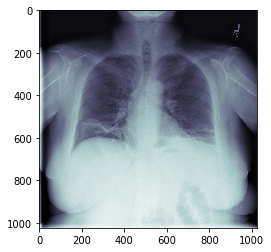

In [116]:
# list(map(save_as_missing_png, missing_keys))

In [29]:
stage_1_train_labels_csv

patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
5      00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0   
6      00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN   
7      006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN   
8      00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0   
9      00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0   
10     008c19e8-a820-403a-930a-bc74a4053664    NaN    NaN    NaN     NaN   
11     009482dc-3db5-48d4-8580-5c89c4f01334    NaN    NaN    NaN     NaN   
12     009eb222-eabc-4150-8121-d5a6d06b8ebf    NaN    NaN    NaN     NaN   
13     00a85be6-6eb0-421d-8acf-ff2dc0007e8a    NaN    NaN    NaN     NaN   
14     00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0   
15     00aecb01-a116-45a2-956c-08d2fa55433f  547.0  299.0  119.0   165.0   
16     00c0b293-48e7-4e16-ac76-9269ba535a62  306.0  544.0  168.0   244.0   
17     00c0b293-48e7-4e16-ac76-9269ba535a62  650.0  511.0  206.0   284.0   
18     00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b    NaN    NaN    NaN     NaN   
19     00f08de1-517e-4652-a04f-d1dc9ee48593  181.0  184.0  206.0   506.0   
20     00f08de1-517e-4652-a04f-d1dc9ee48593  571.0  275.0  230.0   476.0   
21     00f87de5-5fe0-4921-93ea-914d7e683266    NaN    NaN    NaN     NaN   
22     0100515c-5204-4f31-98e0-f35e4b00004a  703.0  416.0   84.0    77.0   
23     01027bc3-dc40-4165-a6c3-d6be2cb7ca34    NaN    NaN    NaN     NaN   
24     010ccb9f-6d46-4380-af11-84f87397a1b8  652.0  437.0  161.0   293.0   
25     010ccb9f-6d46-4380-af11-84f87397a1b8  301.0  405.0  141.0   279.0   
26     011d6f51-b732-4d45-a84d-90477325ef2d    NaN    NaN    NaN     NaN   
27     012a5620-d082-4bb8-9b3b-e72d8938000c  133.0  613.0  275.0   275.0   
28     012a5620-d082-4bb8-9b3b-e72d8938000c  678.0  427.0  224.0   340.0   
29     014b7b58-f641-4477-8bbc-ae6f337745d6    NaN    NaN    NaN     NaN   
...                                     ...    ...    ...    ...     ...   
28959  ffc9e552-ca53-43a8-a156-b0f97f0d40f3    NaN    NaN    NaN     NaN   
28960  ffcc35e8-6fe8-42df-9605-9fedf57240d1    NaN    NaN    NaN     NaN   
28961  ffcfe8c1-5641-4dc3-910c-573e3227f536    NaN    NaN    NaN     NaN   
28962  ffd0c212-bfb6-41e3-b17b-b927b99d1730    NaN    NaN    NaN     NaN   
28963  ffd2bc74-f9d6-49fb-84d7-de060ee22583    NaN    NaN    NaN     NaN   
28964  ffd56560-6754-4a20-83c6-06ad5c4b30ab    NaN    NaN    NaN     NaN   
28965  ffd670a5-b6dc-4f54-928a-69b7a04662eb    NaN    NaN    NaN     NaN   
28966  ffd787b6-59ca-48cb-bd15-bcedd52cf37c  157.0  393.0  237.0   458.0   
28967  ffd787b6-59ca-48cb-bd15-bcedd52cf37c  571.0  238.0  286.0   482.0   
28968  ffdc771e-1f1a-47f7-b732-3e06e48c24e8    NaN    NaN    NaN     NaN   
28969  ffdc8a6a-f513-4a04-9c1d-24840a779220    NaN    NaN    NaN     NaN   
28970  ffdc957e-6239-427d-8a54-fdf8ced3a356    NaN    NaN    NaN     NaN   
28971  ffde3879-241c-4b03-9d91-625cae6b49e8    NaN    NaN    NaN     NaN   
28972  ffde3e7e-849c-4077-bfd0-4e4498ee8817    NaN    NaN    NaN     NaN   
28973  ffe16061-b19f-4333-8a03-b41aab42b47d    NaN    NaN    NaN     NaN   
28974  ffe4707d-517c-4ed0-8a9f-3ad149748991    NaN    NaN    NaN     NaN   
28975  ffe9a1c4-634d-408f-9b0f-8098ffb78a4e    NaN    NaN    NaN     NaN   
28976  ffe9ab5c-9d39-4235-9ade-d725dcad6b76    NaN    NaN    NaN     NaN   
28977  ffeab8ae-f339-40d6-96f1-f1f8c97d2cb1    NaN    NaN    NaN     NaN   
28978  ffee0360-20cf-4d4a-9af5-e5c9b493c73b    NaN    NaN    NaN     NaN   
28979  fff0b503-72a5-446a-843d-f3d152e39053  158.0  267.0  180.0   209.0   
28980 

In [117]:
# Start Work on Classifier

In [28]:
patient_ids = stage_1_train_labels_csv.patientId.values.tolist()

In [123]:
target_values = stage_1_train_labels_csv.Target.values.tolist()

In [124]:
CSV = "../tmp/rsna.csv"

In [125]:
df = pd.DataFrame({'fn': patient_ids, 'cat': target_values}, columns=['fn', 'cat'])

In [126]:
df.to_csv(CSV, index=False)

In [127]:
rsna_path
image_path = "train_png"

In [128]:
md = ImageClassifierData.from_csv(rsna_path, image_path, CSV, tfms=tfms, bs=bs, suffix='.png')

In [129]:
len(stage_1_train_labels_csv)

28989

In [130]:
# list(map(lambda x: f"{x}.png" , patient_ids))

In [131]:
x, y = next(iter(md.val_dl))

In [188]:
?? ImageClassifierData.from_csv(rsna_path, image_path, CSV, tfms=tfms, bs=bs)

In [132]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

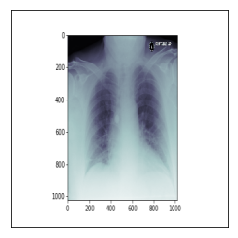

In [133]:
show_img(md.val_ds.denorm(to_np(x))[3])

In [134]:
learn = ConvLearner.pretrained(fmodel, md)

In [135]:
learn.opt_fn = optim.Adam

In [136]:
lrf = learn.lr_find(1e-5, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 300/363 [01:39<00:20,  3.02it/s, loss=2.12] 

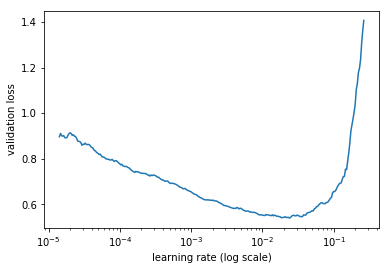

In [137]:
learn.sched.plot()

In [62]:
y

tensor([ 0,  0,  1,  0,  0,  0,  0,  1,  1,  1,  0,  1,  1,  1,
         0,  0,  1,  1,  0,  0,  1,  1,  0,  0,  1,  1,  0,  0,
         0,  0,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  0,  1,  0,  1,  0,  0,  1,  1,  0,  1,  1,  1,
         1,  1,  1,  1,  0,  0,  1,  0], device='cuda:0')

In [138]:
lr = 1e-1

In [120]:
learn.fit(lr, 3, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.499428   0.438175   0.790754  
    1      0.443952   0.493254   0.800069                    
    2      0.545582   0.478726   0.785751                    
    3      0.446543   1.228531   0.793169                    
    4      0.519389   0.457727   0.789546                    
    5      0.436466   13.472978  0.796274                    



[13.472977963885254, 0.79627393492752463]

In [87]:
learn.save('rsna_model_weights_09082018.pth')

In [139]:
learn.load('rsna_model_weights_09082018.pth')

In [69]:
next()md.val_dl

In [68]:
?? learn.predict()

In [140]:
log_preds = learn.predict()

In [141]:
log_preds

array([[-0.00772, -4.86797],
       [-0.32469, -1.28284],
       [-1.08205, -0.41385],
       ..., 
       [-0.47955, -0.96512],
       [-1.26099, -0.3332 ],
       [-1.00313, -0.45686]], dtype=float32)

In [142]:
log_preds[:10]

array([[-0.00772, -4.86797],
       [-0.32469, -1.28284],
       [-1.08205, -0.41385],
       [-0.14468, -2.00472],
       [-0.05935, -2.85382],
       [-0.03965, -3.24739],
       [-0.06358, -2.78712],
       [-0.35609, -1.20534],
       [-0.82314, -0.57812],
       [-0.46317, -0.99232]], dtype=float32)

In [143]:
log_preds[:10][0]

array([-0.00772, -4.86797], dtype=float32)

In [144]:
preds = np.argmax(log_preds, axis=1)

In [145]:
preds

array([0, 0, 1, ..., 0, 1, 1])

In [146]:
preds

array([0, 0, 1, ..., 0, 1, 1])

In [147]:
md.val_ds.y

array([0, 0, 1, ..., 0, 1, 0])

In [148]:
stage_1_train_labels_csv.Target.values.tolist()

[0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,


In [149]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [150]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [151]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

In [103]:
# BB CSV

In [152]:
detailed_class_info_csv[:10]

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
6  00569f44-917d-4c86-a842-81832af98c30  No Lung Opacity / Not Normal
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970  No Lung Opacity / Not Normal
8  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb                  Lung Opacity

In [153]:
stage_1_train_labels_csv[:10]

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

In [78]:
import pdb

In [30]:
def get_bb(row):
    row[2:5]
    x = row[1]
    if math.isnan(float(x)):
        return "0 0 0 0"
    y = row[2]
    width = row[3]
    height = row[4]
    return f"{x} {y} {width} {height}"

In [32]:
def convert_row_to_corners(row):
    row[2:5]
    x = row[1]
    if math.isnan(float(x)):
        return "0 0 0 0"
    y = row[2]
    width = row[3]
    height = row[4]
    
    x2 = x + width
    y2 = y + height
    return f"{x} {y} {x2} {y2}"

In [36]:
v1 = stage_1_train_labels_csv.values.tolist()[4]

In [37]:
get_bb(v1)

'264.0 152.0 213.0 379.0'

In [ ]:
def draw_bbox(row):
    image = row[0]
    bbox = convert_row_to_corners(row)
    

In [43]:
TRAIN_PNG

NameError: name 'TRAIN_PNG' is not defined

In [42]:
image = row[0]

In [41]:
row = v1

In [40]:
v1[0]

'00436515-870c-4b36-a041-de91049b9ab4'

In [34]:
convert_row_to_corners(v1)

'0 0 0 0'

In [35]:
stage_1_train_labels_csv.values.tolist()[:10]

[['0004cfab-14fd-4e49-80ba-63a80b6bddd6', nan, nan, nan, nan, 0],
 ['00313ee0-9eaa-42f4-b0ab-c148ed3241cd', nan, nan, nan, nan, 0],
 ['00322d4d-1c29-4943-afc9-b6754be640eb', nan, nan, nan, nan, 0],
 ['003d8fa0-6bf1-40ed-b54c-ac657f8495c5', nan, nan, nan, nan, 0],
 ['00436515-870c-4b36-a041-de91049b9ab4', 264.0, 152.0, 213.0, 379.0, 1],
 ['00436515-870c-4b36-a041-de91049b9ab4', 562.0, 152.0, 256.0, 453.0, 1],
 ['00569f44-917d-4c86-a842-81832af98c30', nan, nan, nan, nan, 0],
 ['006cec2e-6ce2-4549-bffa-eadfcd1e9970', nan, nan, nan, nan, 0],
 ['00704310-78a8-4b38-8475-49f4573b2dbb', 323.0, 577.0, 160.0, 104.0, 1],
 ['00704310-78a8-4b38-8475-49f4573b2dbb', 695.0, 575.0, 162.0, 137.0, 1]]

In [230]:
bbox = list(map(get_bb, stage_1_train_labels_csv.values.tolist()))

In [231]:
bbox

['0 0 0 0',
 '0 0 0 0',
 '0 0 0 0',
 '0 0 0 0',
 '264.0 152.0 213.0 379.0',
 '562.0 152.0 256.0 453.0',
 '0 0 0 0',
 '0 0 0 0',
 '323.0 577.0 160.0 104.0',
 '695.0 575.0 162.0 137.0',
 '0 0 0 0',
 '0 0 0 0',
 '0 0 0 0',
 '0 0 0 0',
 '288.0 322.0 94.0 135.0',
 '547.0 299.0 119.0 165.0',
 '306.0 544.0 168.0 244.0',
 '650.0 511.0 206.0 284.0',
 '0 0 0 0',
 '181.0 184.0 206.0 506.0',
 '571.0 275.0 230.0 476.0',
 '0 0 0 0',
 '703.0 416.0 84.0 77.0',
 '0 0 0 0',
 '652.0 437.0 161.0 293.0',
 '301.0 405.0 141.0 279.0',
 '0 0 0 0',
 '133.0 613.0 275.0 275.0',
 '678.0 427.0 224.0 340.0',
 '0 0 0 0',
 '0 0 0 0',
 '0 0 0 0',
 '155.0 182.0 273.0 501.0',
 '599.0 220.0 227.0 508.0',
 '0 0 0 0',
 '0 0 0 0',
 '229.0 318.0 250.0 301.0',
 '604.0 216.0 196.0 328.0',
 '0 0 0 0',
 '0 0 0 0',
 '0 0 0 0',
 '141.0 306.0 225.0 327.0',
 '609.0 285.0 236.0 355.0',
 '214.0 582.0 239.0 133.0',
 '664.0 540.0 223.0 203.0',
 '0 0 0 0',
 '225.0 415.0 98.0 101.0',
 '0 0 0 0',
 '0 0 0 0',
 '366.0 289.0 208.0 527.0',
 '71

In [27]:
BBOX_CSV = "../tmp/rsna_bbox.csv"
df = pd.DataFrame({'fn': patient_ids, 'bbox': bbox}, columns=['fn', 'bbox'])
df.to_csv(BBOX_CSV, index=False)

NameError: name 'patient_ids' is not defined

In [84]:
BBOX_CSV_SAMPLE = "../tmp/rsna_bbox_sample.csv"
df = pd.DataFrame({'fn': patient_ids, 'bbox': bbox}, columns=['fn', 'bbox'])
df = df[df['bbox']!= "0 0 0 0"]
df = df[:1000]
df.to_csv(BBOX_CSV_SAMPLE, index=False)

In [26]:
BBOX_CSV

NameError: name 'BBOX_CSV' is not defined

In [24]:
f_model=resnet34
sz=224
bs=64

In [25]:
augs = [RandomFlip(), 
        RandomRotate(30),
        RandomLighting(0.1,0.1)]

In [358]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(rsna_path, image_path, BBOX_CSV, tfms=tfms, test_name=test_path, continuous=True, bs=4, suffix='.png')

In [257]:
?? ImageClassifierData.from_csv

In [256]:
image_path

'train_png'

In [23]:
test_path = 'test2_png'

In [259]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(rsna_path, image_path, BBOX_CSV_SAMPLE, tfms=tfms, test_name=test_path, continuous=True, bs=4, suffix='.png')

NameError: name 'BBOX_CSV_SAMPLE' is not defined

In [89]:
md.val_ds.y

array([[ 703.,  416.,   84.,   77.],
       [ 225.,  415.,   98.,  101.],
       [ 714.,  278.,  255.,  576.],
       [ 664.,  380.,  141.,  330.],
       [ 669.,  449.,  162.,  284.],
       [ 617.,  269.,  208.,  420.],
       [ 616.,  306.,  180.,  475.],
       [ 616.,  306.,  180.,  475.],
       [ 239.,  352.,  121.,   93.],
       [ 610.,  599.,  265.,  245.],
       [ 210.,  396.,  182.,  493.],
       [ 284.,  170.,  215.,  571.],
       [ 591.,  242.,  187.,  333.],
       [ 185.,  408.,  188.,  307.],
       [ 637.,  240.,  242.,  547.],
       [ 381.,  613.,  108.,  162.],
       [ 349.,  735.,  173.,  172.],
       [ 160.,  264.,  317.,  501.],
       [ 259.,  499.,  202.,  269.],
       [ 563.,  619.,  334.,  241.],
       [ 459.,  246.,  351.,  645.],
       [ 275.,  194.,  307.,  498.],
       [ 581.,  382.,  313.,  223.],
       [ 467.,  218.,  298.,  545.],
       [  87.,  414.,  241.,  201.],
       [  87.,  414.,  241.,  201.],
       [ 152.,  383.,  215.,  240.],
 

In [361]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [240]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

In [241]:
learn.lr_find(1e-5, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 67%|██████▋   | 3913/5798 [01:45<00:50, 37.23it/s, loss=306] 

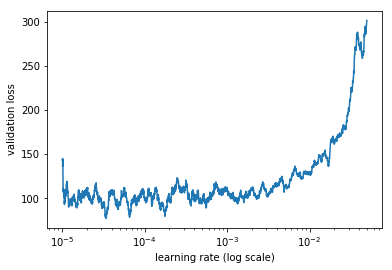

In [242]:
learn.sched.plot(5)

In [243]:
lr = 1e-2

In [244]:
learn.predict()

array([[-1.08596,  1.01164, -1.76225, -1.98897],
       [-0.91225,  1.04755, -0.92104, -1.0867 ],
       [-0.08994,  0.38208, -0.80503, -1.79257],
       ..., 
       [-0.16289,  1.0757 , -0.85852, -1.62023],
       [-0.62177,  0.99247, -0.96274, -2.1972 ],
       [-0.48912,  1.33406, -0.7488 , -3.16357]], dtype=float32)

In [276]:
x_test, y_test = next(iter(md.test_dl))

In [277]:
x_test

tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
     

In [245]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  3%|▎         | 156/5798 [00:03<02:22, 39.47it/s, loss=101]

Exception in thread Thread-29:
Traceback (most recent call last):
  File "/home/edwin/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/edwin/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/edwin/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                 
    0      87.549214  95.156782 
    1      98.289711  95.816253                                
    2      101.252108 95.650374                                



[95.650374046169063]

In [246]:
learn.save('reg4')

In [ ]:
learn.load()

In [247]:
learn.predict()

array([[  57.49495,   34.00206,   70.55927,   59.0043 ],
       [  57.94235,   19.50297,    3.40042,   43.04851],
       [ 129.65228,  125.33691,  117.82594,  162.3636 ],
       ..., 
       [  52.40249,   56.9976 ,   61.57693,   68.02984],
       [ 126.42829,  136.6868 ,  166.77144,  176.26273],
       [ 220.69431,  237.78606,  178.23451,  235.72813]], dtype=float32)

In [248]:
x, y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

In [249]:
y

tensor([[   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [ 650.,  511.,  206.,  284.],
        [   0.,    0.,    0.,    0.]], device='cuda:0')

In [252]:
preds

array([[  57.49495,   34.00206,   70.55927,   59.0043 ],
       [  57.94235,   19.50297,    3.40042,   43.04851],
       [ 129.65228,  125.33691,  117.82594,  162.3636 ],
       [  23.40086,   20.26207,    9.79642,   18.26331]], dtype=float32)

In [89]:
ima = md.val_ds.ds.denorm(to_np(x))[3]

AttributeError: 'FilesIndexArrayRegressionDataset' object has no attribute 'ds'

In [253]:
learn.save("regggg5.pth")

In [362]:
learn.load("regggg5.pth")

In [267]:
md.test_ds

In [99]:
preds[3]

array([ 38.93356,  43.91233,  42.31933,  44.09192], dtype=float32)

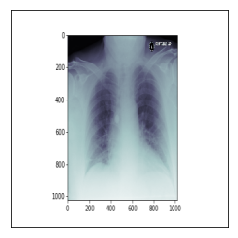

In [98]:
show_img(md.val_ds.denorm(to_np(x))[3])

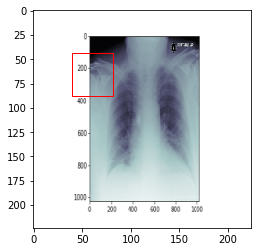

In [103]:
fig, ax = plt.subplots(1)
ax.imshow(ima, cmap=plt.cm.bone)
_x, _y, _width, _height = preds[3]
rect = Rectangle((_x,_y),_width,_height,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

In [101]:
ima = md.val_ds.denorm(to_np(x))[3]

In [91]:
stage_1_sample_submission_csv

patientId PredictionString
0    000924cf-0f8d-42bd-9158-1af53881a557  0.5 0 0 100 100
1    000db696-cf54-4385-b10b-6b16fbb3f985  0.5 0 0 100 100
2    000fe35a-2649-43d4-b027-e67796d412e0  0.5 0 0 100 100
3    001031d9-f904-4a23-b3e5-2c088acd19c6  0.5 0 0 100 100
4    0010f549-b242-4e94-87a8-57d79de215fc  0.5 0 0 100 100
5    001916b8-3d30-4935-a5d1-8eaddb1646cd  0.5 0 0 100 100
6    0022073f-cec8-42ec-ab5f-bc2314649235  0.5 0 0 100 100
7    0022995a-45eb-4cfa-9a59-cd15f5196c64  0.5 0 0 100 100
8    0025d2de-bd78-4d36-9f72-e15a5e22ca82  0.5 0 0 100 100
9    00293de0-a530-41dc-9621-0b3def01d06d  0.5 0 0 100 100
10   002c591d-df62-4e34-8eda-838c664430a9  0.5 0 0 100 100
11   002cb550-2e31-42f1-a29d-fbc279977e71  0.5 0 0 100 100
12   0049f7b2-229b-4a46-91a3-0e321a3ca80a  0.5 0 0 100 100
13   0053ee32-1e03-4dc2-a103-f46ad0448787  0.5 0 0 100 100
14   005f5517-ab76-4b0d-8a26-f808d97171c4  0.5 0 0 100 100
15   0067d70b-0e6d-41ff-a9b8-8edf6d5e25e4  0.5 0 0 100 100
16   006e75c8-1fd9-4a5a-99e7-285addebed55  0.5 0 0 100 100
17   0087bd3a-55a7-4045-b111-b018fa52d361  0.5 0 0 100 100
18   0088be53-27f2-4c30-882b-a73a3a5c8c71  0.5 0 0 100 100
19   008b69b2-446a-43dd-9ba2-9ccff8f3da41  0.5 0 0 100 100
20   0092d9c5-26b6-4e66-b196-49b2224ab8d1  0.5 0 0 100 100
21   00a05408-8291-4231-886e-13763e103161  0.5 0 0 100 100
22   00dd08bb-b7ea-4617-801e-02b3051c3475  0.5 0 0 100 100
23   00ddefb9-d94e-4e86-b945-970be30483d7  0.5 0 0 100 100
24   00ec0d87-8e2a-44bd-b79c-4b91cfabcacf  0.5 0 0 100 100
25   00eeb3c9-a892-4fac-a67a-aaa6cc7ffd5c  0.5 0 0 100 100
26   00f2de16-a231-40c3-9a5f-8198f530a4b0  0.5 0 0 100 100
27   00fcc4f0-d7b5-4473-99a9-aa7d3ca071c9  0.5 0 0 100 100
28   0101174b-6643-4d4e-b4ba-b6d41d0ce46a  0.5 0 0 100 100
29   0103fadb-1663-40a6-8a9e-09d626cd2091  0.5 0 0 100 100
..                                    ...              ...
970  c106ddba-42f7-440c-9ba9-f3fa6692f06f  0.5 0 0 100 100
971  c10726b6-c944-403f-9062-f0bf922ef149  0.5 0 0 100 100
972  c109061a-d815-4cae-8343-9230d8024adf  0.5 0 0 100 100
973  c1098ce4-cb15-41c6-ba39-1fa511b82100  0.5 0 0 100 100
974  c10ae3e5-822f-49e9-8c02-b0e2a98eddc1  0.5 0 0 100 100
975  c110e1ed-fb28-4b3d-b450-e370f13d4293  0.5 0 0 100 100
976  c1265ac3-6eae-4cf3-9880-26fd430312f3  0.5 0 0 100 100
977  c1273696-fdec-48a9-988c-74e57b6323fa  0.5 0 0 100 100
978  c12aafdd-4d21-4cd3-a2ae-007bce2e2fc0  0.5 0 0 100 100
979  c1415e26-fddf-4a0c-a7eb-7b9a0d9e9983  0.5 0 0 100 100
980  c145df8e-9631-468d-af7f-5690c11c2c88  0.5 0 0 100 100
981  c14d9ceb-019f-45f6-9299-281b58de57df  0.5 0 0 100 100
982  c1592aae-c80d-4794-ab28-463905558534  0.5 0 0 100 100
983  c1628c47-5ba3-42dd-8df3-7ad3abd57ad0  0.5 0 0 100 100
984  c164b17b-aff8-484f-9d9e-dde2932d8df9  0.5 0 0 100 100
985  c1718678-44af-407f-829a-fc65bc854094  0.5 0 0 100 100
986  c18d1138-ba74-4af5-af21-bdd4d2c96bb5  0.5 0 0 100 100
987  c196ce23-f37c-4ab3-a9ce-ea8ede90e09c  0.5 0 0 100 100
988  c19b8a3b-ab4e-4a73-8e13-ec0a84b6b6c7  0.5 0 0 100 100
989  c1c3ec5d-20ba-42f7-91f9-48032d97ffc9  0.5 0 0 100 100
990  c1ca4417-83a6-43a7-a9bf-7d9587e7f14f  0.5 0 0 100 100
991  c1cddf32-b957-4753-acaa-472ab1447e86  0.5 0 0 100 100
992  c1cf3255-d734-4980-bfe0-967902ad7ed9  0.5 0 0 100 100
993  c1e228e4-b7b4-432b-a735-36c48fdb806f  0.5 0 0 100 100
994  c1e3eb82-c55a-471f-a57f-fe1a823469da  0.5 0 0 100 100
995  c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2  0.5 0 0 100 100
996  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  0.5 0 0 100 100
997  c1edf42b-5958-47ff-a1e7-4f23d99583ba  0.5 0 0 100 100
998  c1f6b555-2eb1-4231-98f6-50a963976431  0.5 0 0 100 100
999  c1f7889a-9ea9-4acb-b64c-b737c929599a  0.5 0 0 100 100

[1000 rows x 2 columns]

In [93]:
CSV_FINAL = "../tmp/rsna_prediction.csv"

In [95]:
prediction_string = "confidence x y width height"

In [92]:
df_result = pd.DataFrame({"patientId": [], "PredictionString": []}, columns=["patientId", "PredictionString"])

In [94]:
df_result.to_csv(CSV_FINAL, index=False)

In [175]:
len(test_images)

25684

In [181]:
test_png_images = Path(TEST_PNG_PATH)

In [183]:
test_png_images = list(test_png_images.glob('*.png'))

In [184]:
len(test_png_images)

23258

In [189]:
get_stem(test_png_images[0])

'38e68dfa-d76e-4d4a-9fa8-4a9d86f1a380'

In [188]:
def get_stem(file):
    return file.stem

In [196]:
test_images_keys = set(list(map(get_stem, test_images)))

In [193]:
test_png_images_keys = set(list(map(get_stem, test_png_images)))

In [210]:
missing_test_images = test_images_keys - test_png_images_keys
missing_test_images = list(missing_test_images)
missing_test_images = list(map(return_path, missing_test_images))

In [202]:
len(missing_test_images)

2426

In [203]:
def save_as_png_test(file):
    key = str(file).split('/')[-1].split('.dcm')[0]
    ds = pydicom.dcmread(str(file))
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    png_path = f"{TEST_PNG_PATH}{key}.png"
    if os.path.isfile(png_path) and os.access(png_path, os.R_OK):
        print("FILE EXISTS. SKIPPING")
    else:
        plt.savefig(png_path)

In [206]:
key = missing_test_images[0]

In [205]:
test_images[0]

PosixPath('/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/test/b215a2cf-ddf6-4032-99a0-1c2b10ef2f9e.dcm')

In [208]:
def return_path(key):
    return f"/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/test/{key}.dcm"

In [209]:
return_path(key)

'/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/test/d6cc8a62-2d18-4257-bcfd-079e3b0cf441.dcm'

In [212]:
file = missing_test_images[0]

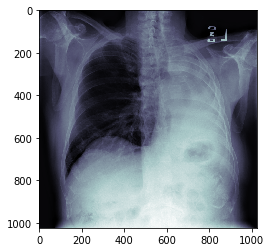

In [213]:
save_as_png_test(file)

In [214]:
p = Pool(4)

                                                            

                                                            

FILE EXISTS. SKIPPING


Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/edwin/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/edwin/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/edwin/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/edwin/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/edwin/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/edwin/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/edwin/anaconda3/lib/python3.6/multip

In [363]:
preds = learn.predict(is_test=True)

In [215]:
# p.map(save_as_png_test, missing_test_images)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [216]:
len(detailed_class_info_csv)

28989

In [217]:
detailed_class_info_csv[:5]

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [279]:
for i, x_test in enumerate(md.test_dl):
    md.test_ds.fnames[]
    print(x_test)

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

[tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          ...,
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
            2.2489e+00,  2.2489e+00]],

         [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
            2.4286e+00,  2.4286e+00],
          ...,
    

KeyboardInterrupt: 

In [287]:
i, x_test = next(enumerate(md.test_dl))

In [285]:
len(md.test_dl)

6421

In [290]:
next(enumerate(md.test_dl))

(0, [tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
              2.2489e+00,  2.2489e+00],
            [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
              2.2489e+00,  2.2489e+00],
            [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
              2.2489e+00,  2.2489e+00],
            ...,
            [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
              2.2489e+00,  2.2489e+00],
            [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
              2.2489e+00,  2.2489e+00],
            [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  2.2489e+00,
              2.2489e+00,  2.2489e+00]],
  
           [[ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
              2.4286e+00,  2.4286e+00],
            [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
              2.4286e+00,  2.4286e+00],
            [ 2.4286e+00,  2.4286e+00,  2.4286e+00,  ...,  2.4286e+00,
              2.4

In [292]:
test_preds = learn.predict(is_test=True)

In [294]:
test_preds[0]

array([ 20.87355,  14.06686,  18.32669,  17.68617], dtype=float32)

In [297]:
len()

25684

In [298]:
md.test_ds.fnames, test_preds

(['test_png/38e68dfa-d76e-4d4a-9fa8-4a9d86f1a380.png',
  'test_png/b128e033-c42f-4f15-ae68-6478c120da86.png',
  'test_png/020a16e3-baf9-4cf0-859c-c79b5253d717.png',
  'test_png/87e3961c-a02b-4a1b-80cc-a0f942897521.png',
  'test_png/04a6aa6d-bd6d-48b1-822b-21b81c4bdf3a.png',
  'test_png/86f084ef-539c-404b-9a91-c9a5d5ab3771.png',
  'test_png/77326677-302c-48aa-b578-953e266790d5.png',
  'test_png/c27f0d34-8752-4875-89ab-dd5f830ea81c.png',
  'test_png/3fad6559-5289-4da1-a682-df0c97a08e38.png',
  'test_png/d033b43a-a7c4-4ded-b2c1-000d41c6f2cc.png',
  'test_png/89b91e46-f1f4-416c-abbf-8b0e2131f549.png',
  'test_png/3993a64f-ab45-4594-abe9-2807e19a1d71.png',
  'test_png/7b433c27-746c-4968-b958-397f1e81e36c.png',
  'test_png/317ee2f4-c102-4558-b6c4-3a613f01bf84.png',
  'test_png/b3cbe758-859f-4ace-8968-4953ca48dfc7.png',
  'test_png/fe9c2c9d-7028-4091-8b78-8799edc65aaf.png',
  'test_png/ce81a461-251f-4fdd-8222-a6eb7fbd6e1c.png',
  'test_png/adc7c661-7098-4fbf-bace-8de5dc3e19d9.png',
  'test_pn

In [304]:
md.test_ds.fnames[0].split('/')[1].split('.png')[0]

['38e68dfa-d76e-4d4a-9fa8-4a9d86f1a380', '']

In [305]:
def get_key(fname):
    return fname.split('/')[1].split('.png')[0]

In [309]:
def get_pred(pred):
    x, y, width, height = pred.tolist()
    return f"1.0 {x} {y} {width} {height}"

In [310]:
get_pred(test_preds[0])

'1.0 20.873546600341797 14.066856384277344 18.32669448852539 17.686166763305664'

In [308]:
test_preds[0].tolist()

[20.873546600341797, 14.066856384277344, 18.32669448852539, 17.686166763305664]

In [306]:
get_key(md.test_ds.fnames[0])

'38e68dfa-d76e-4d4a-9fa8-4a9d86f1a380'

In [365]:
fnames = list(map(get_key, md.test_ds.fnames))
pred_strings = list(map(get_pred, preds))
test_pairs = list(zip(fnames, pred_strings))

In [366]:
len(test_pairs)

1000

In [ ]:
from IPython.display import FileLink

In [367]:
TEST_CSV = '../tmp/rsna_test_predictions.csv'
df_test = pd.DataFrame(test_pairs, columns=["patientId", "PredictionString"])
df_test.to_csv(TEST_CSV, index=False)
FileLink(TEST_CSV)

/home/edwin/Developer/kaggle-comps/tmp/rsna_test_predictions.csv

In [322]:
test_patient_ids = stage_1_sample_submission_csv.patientId.values

In [324]:
len(test_patient_ids)

1000

In [332]:
def findPrediction(patientId):
    return df_test[df_test.patientId == patientId].PredictionString.values[0]

In [340]:
patientId = df_test.patientId[0]
df_test[df_test.patientId == patientId].PredictionString.values[0]

'1.0 20.873546600341797 14.066856384277344 18.32669448852539 17.686166763305664'

In [338]:
test_patient_ids[0]

'000924cf-0f8d-42bd-9158-1af53881a557'

In [333]:
findPrediction(test_patient_ids[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [341]:
test_patient_ids

array(['000924cf-0f8d-42bd-9158-1af53881a557', '000db696-cf54-4385-b10b-6b16fbb3f985',
       '000fe35a-2649-43d4-b027-e67796d412e0', '001031d9-f904-4a23-b3e5-2c088acd19c6',
       '0010f549-b242-4e94-87a8-57d79de215fc', '001916b8-3d30-4935-a5d1-8eaddb1646cd',
       '0022073f-cec8-42ec-ab5f-bc2314649235', '0022995a-45eb-4cfa-9a59-cd15f5196c64',
       '0025d2de-bd78-4d36-9f72-e15a5e22ca82', '00293de0-a530-41dc-9621-0b3def01d06d',
       '002c591d-df62-4e34-8eda-838c664430a9', '002cb550-2e31-42f1-a29d-fbc279977e71',
       '0049f7b2-229b-4a46-91a3-0e321a3ca80a', '0053ee32-1e03-4dc2-a103-f46ad0448787',
       '005f5517-ab76-4b0d-8a26-f808d97171c4', '0067d70b-0e6d-41ff-a9b8-8edf6d5e25e4',
       '006e75c8-1fd9-4a5a-99e7-285addebed55', '0087bd3a-55a7-4045-b111-b018fa52d361',
       '0088be53-27f2-4c30-882b-a73a3a5c8c71', '008b69b2-446a-43dd-9ba2-9ccff8f3da41',
       '0092d9c5-26b6-4e66-b196-49b2224ab8d1', '00a05408-8291-4231-886e-13763e103161',
       '00dd08bb-b7ea-4617-801e-02b3051c347

In [345]:
test_images = list(Path('/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/test2/').glob('*.dcm'))

In [350]:
test_png_path = '/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge/test2_png/'

In [351]:
def save_as_png_test(file):
    key = str(file).split('/')[-1].split('.dcm')[0]
    ds = pydicom.dcmread(str(file))
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    png_path = f"{test_png_path}{key}.png"
    if os.path.isfile(png_path) and os.access(png_path, os.R_OK):
        print("FILE EXISTS. SKIPPING")
    else:
        plt.savefig(png_path)

In [356]:
len(list(Path(test_png_path).glob('*.png')))

1000

In [364]:
len(preds)

1000

In [1]:
preds

NameError: name 'preds' is not defined